# Install and import libraries

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statistics

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import transformers
from transformers import BertForTokenClassification, AdamW
from transformers import get_linear_schedule_with_warmup

from seqeval.metrics import f1_score, accuracy_score

2023-09-18 19:25:31.935012: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Check GPU availability

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'NVIDIA A100-PCIE-40GB'

# **Preprocessing data**

In [3]:
# Reading data
import json


#open the file, and format correctly
f =open('all.jsonl', 'r')
json_object = json.dumps(f.readlines(), indent=4)
f.close()

#save better format into file
p = open('sample.txt', 'w')
for i in json_object:
    p.write(i)
p.close()

#open new file, and save each 
j = open('sample.txt', 'r')
text = json.loads(j.read())
j.close()

#compile all json dicts into a list
info = []
for i in text:
    info.append(json.loads(str(i)))
    

In [4]:
info[0]['entities']

[{'id': 10624, 'label': 'Acid', 'start_offset': 242, 'end_offset': 248},
 {'id': 10625, 'label': 'Acid', 'start_offset': 231, 'end_offset': 241},
 {'id': 10626, 'label': 'Acid', 'start_offset': 65, 'end_offset': 69},
 {'id': 10627, 'label': 'Acid', 'start_offset': 41, 'end_offset': 63},
 {'id': 10632, 'label': 'Metal', 'start_offset': 139, 'end_offset': 144},
 {'id': 10633, 'label': 'Acid', 'start_offset': 178, 'end_offset': 199},
 {'id': 10634, 'label': 'Acid', 'start_offset': 302, 'end_offset': 307},
 {'id': 10635, 'label': 'Acid', 'start_offset': 312, 'end_offset': 334},
 {'id': 10636,
  'label': 'Organic solvent',
  'start_offset': 366,
  'end_offset': 374},
 {'id': 15947,
  'label': 'Separation Method',
  'start_offset': 76,
  'end_offset': 94},
 {'id': 15948,
  'label': 'Separation Method',
  'start_offset': 96,
  'end_offset': 99},
 {'id': 15949,
  'label': 'Separation Method',
  'start_offset': 104,
  'end_offset': 127},
 {'id': 15950,
  'label': 'Separation Method',
  'start_o

In [4]:
def degreekify(char):
    #char will be a character
    greek = {'α': '[alpha]', 'β':'[beta]', 'γ': '[gamma]', 'δ':'[delta]', 'ε': '[epsilon]', 'ζ':'[zeta]', 'η': '[eta]',
            'θ':'[theta]', 'ι': '[iota]', 'κ':'[kappa]', 'λ':'[lambda]', 'μ': '[mu]', 'ν':'[nu]', 'ξ':'[xi]', 'ο':'[omicron]', 'π':'[pi]', 'ρ':'[rho]',
            'σ': '[sigma]', 'τ': '[tau]', 'υ':'[upsilon]', 'φ':'[phi]', 'χ':'[chi]', 'ψ':'[psi]', 'ω':'[omega]' }
    if char in greek:
        return greek[char]
    else:
        return char

In [5]:
def pre_process(text, annotations):
    #text will be the straight sentence, info[i]['text']
    #annotations will be the list of labels, must be info[i]['annotations']
    
    text_dict = []
    
    for i in range(len(text)):
        text_dict.append(degreekify(text[i]))
    
    
    
    ann_indices = []
    def fun(x):
        return x['start_offset']
    annotations.sort(key=fun)
    
    
    
    if len(annotations)==0:
        ann_indices.append([[0, len(text)],0])
    else:
        ann_indices.append([[0, annotations[0]['start_offset']], 0])
        for i in range(len(annotations)-1):
            ann_indices.append([[annotations[i]['start_offset'], annotations[i]['end_offset']], data_tags.index(annotations[i]['label'])])
            ann_indices.append([[annotations[i]['end_offset'], annotations[i+1]['start_offset']], 0])
            
        ann_indices.append([[annotations[-1]['start_offset'], annotations[-1]['end_offset']], data_tags.index(annotations[-1]['label'])])
        ann_indices.append([[annotations[-1]['end_offset'], len(text)], 0])
         
    
    labels = []
    sentences = []
    for a in ann_indices:
        
        if a[0][1]-a[0][0] !=0:
            together = ''
            for i in range(a[0][0], a[0][1]):
                together += text_dict[i]
                
            toke = together.split()
            sentences.extend(toke)
            t = len(toke)
            if t != 0:
                temp = [data_tags[a[1]+1]] * t
                if a[1] != 0:
                    temp[0] = data_tags[a[1]]
                labels.extend(temp)
 
    return labels, sentences

In [6]:
def reduce(sent, label, slist, llist):
    lens = len(sent)
    if lens < 256:
        slist.append(sent)
        llist.append(label)
    else:
        t = lens//2
        return reduce(sent[:t], label[:t], slist, llist), reduce(sent[t:], label[t:], slist, llist)

In [7]:
#create labels
data_tags = ['ahhhhhhhhhhhhhhhhhhhh','0','Metal', 'M-cont' , 'Element', 'E-cont', 'Acid', 'A-cont', 'Yield' , 'Y-cont', 'Separation Method' , 'S-cont', 'Resin', 'R-cont', 'Method of Analysis', 'T-cont', 'pH', 'P-cont', 'Chemical Compound', 'H-cont', 'Organic solvent', 'O-cont', 'Element Group', 'G-cont', 'Inorganic Solvent', 'I-cont', 'Flowrate', 'F-cont', 'Acid Concentration', 'C-cont', 'Reagent', 'X-cont']

sent_test, label_test = [], []
sentences, labels = [], []

for i in range(len(info)):
    l, s = pre_process(info[i]['text'], info[i]['entities'])
  
    if i % 5 == 0:
        reduce(s,l,sent_test, label_test)

    else:
        reduce(s,l,sentences, labels)


data_tags = data_tags[1:]


In [8]:

# Determine the list of tags
tag_values = data_tags
print(tag_values)

tag_values.append("PAD")
print(tag_values)

tag2idx = {t: i for i, t in enumerate(tag_values)}
print(tag2idx)
    
    
idx2tag = {value: key for key, value in tag2idx.items()}

['0', 'Metal', 'M-cont', 'Element', 'E-cont', 'Acid', 'A-cont', 'Yield', 'Y-cont', 'Separation Method', 'S-cont', 'Resin', 'R-cont', 'Method of Analysis', 'T-cont', 'pH', 'P-cont', 'Chemical Compound', 'H-cont', 'Organic solvent', 'O-cont', 'Element Group', 'G-cont', 'Inorganic Solvent', 'I-cont', 'Flowrate', 'F-cont', 'Acid Concentration', 'C-cont', 'Reagent', 'X-cont']
['0', 'Metal', 'M-cont', 'Element', 'E-cont', 'Acid', 'A-cont', 'Yield', 'Y-cont', 'Separation Method', 'S-cont', 'Resin', 'R-cont', 'Method of Analysis', 'T-cont', 'pH', 'P-cont', 'Chemical Compound', 'H-cont', 'Organic solvent', 'O-cont', 'Element Group', 'G-cont', 'Inorganic Solvent', 'I-cont', 'Flowrate', 'F-cont', 'Acid Concentration', 'C-cont', 'Reagent', 'X-cont', 'PAD']
{'0': 0, 'Metal': 1, 'M-cont': 2, 'Element': 3, 'E-cont': 4, 'Acid': 5, 'A-cont': 6, 'Yield': 7, 'Y-cont': 8, 'Separation Method': 9, 'S-cont': 10, 'Resin': 11, 'R-cont': 12, 'Method of Analysis': 13, 'T-cont': 14, 'pH': 15, 'P-cont': 16, 'Chemi

In [9]:
bio_labels = [
    'O',
    'B-Metal',
    'I-Metal',
    'B-Element',
    'I-Element',
    'B-Acid',
    'I-Acid',
    'B-Yield',
    'I-Yield',
    'B-SeparationMethod',
    'I-SeparationMethod',
    'B-Resin',
    'I-Resin',
    'B-MethodOfAnalysis',
    'I-MethodOfAnalysis',
    'B-pH',
    'I-pH',
    'B-ChemicalCompound',
    'I-ChemicalCompound',
    'B-OrganicSolvent',
    'I-OrganicSolvent',
    'B-ElementGroup',
    'I-ElementGroup',
    'B-InorganicSolvent',
    'I-InorganicSolvent',
    'B-Flowrate',
    'I-Flowrate',
    'B-AcidConcentration',
    'I-AcidConcentration',
    'B-Reagent',
    'I-Reagent',
    'O'
]


## begin to use huggingface dataset

In [10]:
from datasets import Dataset
tokenizer = BertTokenizer.from_pretrained('allenai/scibert_scivocab_cased', do_lower_case=False)
data_list = [{'tokens':x, 'tags':y} for x, y in zip(sentences, labels) ]
text_data = Dataset.from_list(data_list)

In [11]:
def tokenize_and_preserve_labels(sentence, text_labels): #### this function requires to add 
    # more work on how to add labels
    tokenized_inputs = tokenizer(sentence, truncation=True, is_split_into_words=True)
    #tokenized_sentence = []
    labels = [-100]

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        
        n_subwords = len(tokenized_word)
        #print(word, tokenized_word, n_subwords)

        # Add the tokenized word to the final tokenized word list
        #tokenized_ids = [tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_word]
        #tokenized_sentence.extend(tokenized_ids)

        # Add the same label to the new list of labels `n_subwords` times
        labels.append(tag2idx[label])
        if n_subwords>1:
            labels.extend([-100] * (n_subwords-1))
        #labels.extend([tag2idx[label]] * n_subwords) #### TODO: this extend should change I to I-cont, but keep I-cont

        # tokenized_sentence2 = pad_sequences(tokenized_sentence,
        #                   maxlen=MAX_LEN, dtype="long", value=0.0,
        #                   truncating="post", padding="post")
        # labels2 = pad_sequences(labels,
        #              maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
        #              dtype="long", truncating="post")
        
    labels.append(-100)
    return tokenized_inputs, labels

def tokenize_text(example):
    sent = example['tokens']
    labs = example['tags']
    example, labels = tokenize_and_preserve_labels(sent, labs)
    example['labels'] = labels
    return example

### tokenized data

In [12]:

tokenized_data = text_data.map(tokenize_text)
tokenized_data = tokenized_data.remove_columns(['tokens', 'tags'])
tokenized_data = tokenized_data.train_test_split(test_size=0.5)

Map:   0%|          | 0/344 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [13]:
import wandb
wandb.login()


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: lemon15203 (bnl-lemon). Use `wandb login --relogin` to force relogin


True

# **Build model**

In [14]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer

# model = AutoModelForTokenClassification.from_pretrained(
#     "distilbert-base-uncased", num_labels=13, id2label=id2label, label2id=label2id
# )

In [15]:
# Load SciBERT Model

model = AutoModelForTokenClassification.from_pretrained(
    "checkpoint-242500", # "allenai/scibert_scivocab_cased",
    num_labels=len(tag2idx), # The number of output labels
    output_attentions = False, # Whether the model returns attention weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
    id2label=idx2tag, label2id=tag2idx
    
)

Some weights of the model checkpoint at checkpoint-242500 were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at checkpoint-242500 and are newly initial

In [16]:
import evaluate

seqtest = evaluate.load("seqeval")

def compute_metrics(p):
    predictions, labels = p
    #predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [idx2tag[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [idx2tag[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [17]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr= 3e-5, # learning-rate default is 3e-5
    eps=1e-20 # adam-epsilon default is 1e-8
)

/global/homes/g/gzhao27/anaconda3/lib/python3.11/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [18]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

from torch.utils.data import DataLoader
train_loader = DataLoader(tokenized_data['train'], batch_size = 4, collate_fn=data_collator)
val_loader = DataLoader(tokenized_data['test'], collate_fn=data_collator)

In [19]:
epochs = 20
max_grad_norm = 1.0
model.to(device)
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps= 0,
    num_training_steps=total_steps
)
wandb.init(
    # Set the project where this run will be logged
    project="my-awesome-project",)


loss_values, validation_loss_values = [], []

for e in range(epochs):
    
    
    
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_loader):
        # add batch to gpu
        batch = {k:v.to(device) for k, v in batch.items()}
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(**batch)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_loader)
    print("\nAverage train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in val_loader:
        batch = {k:v.to(device) for k, v in batch.items()}

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(**batch)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = batch['labels'].to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)
    eval_loss = eval_loss / len(val_loader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [
        [bio_labels[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, true_labels)
    ]
    valid_tags = [
        [bio_labels[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, true_labels)
    ]
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    wandb.log({"Validation loss": eval_loss, "training loss": avg_train_loss, 
            "Accuracy": accuracy_score(pred_tags, valid_tags),
            "F1-Score": f1_score(pred_tags, valid_tags, average=None),
            })
    # f1_scores = f1_score(pred_tags, valid_tags, average=None)
    # for i in range(len(f1_scores)):
    #     wandb.log({str(i):f1_scores[i]})
    
    #print()
    # a = eval_loss
    # test_acc.append(a)
    # if a <= max_test:
    #     max_test = a
    # elif  max_test * 1.05 >= a and max_test < a:    
    #     torch.save(model, "check.ck")


Average train loss: 0.8126525823460069
Validation loss: 0.35925723200793874
Validation Accuracy: 0.9246484961550712
Validation F1-Score: 0.6314715633766895

Average train loss: 0.31610272798773853
Validation loss: 0.27629258534004697
Validation Accuracy: 0.9393456795741002
Validation F1-Score: 0.6979166666666667

Average train loss: 0.20221600369658582
Validation loss: 0.23836388795157396
Validation Accuracy: 0.9467170223415389
Validation F1-Score: 0.72903707389898

Average train loss: 0.13088170908997918
Validation loss: 0.23531666572705226
Validation Accuracy: 0.9517222550848614
Validation F1-Score: 0.7662758792716388

Average train loss: 0.09320319630205631
Validation loss: 0.2659177307875727
Validation Accuracy: 0.9522227783591937
Validation F1-Score: 0.7735705209656925

Average train loss: 0.07142186155109558
Validation loss: 0.24785729117375435
Validation Accuracy: 0.9551804158893389
Validation F1-Score: 0.7786106946526736

Average train loss: 0.05809162540881093
Validation loss

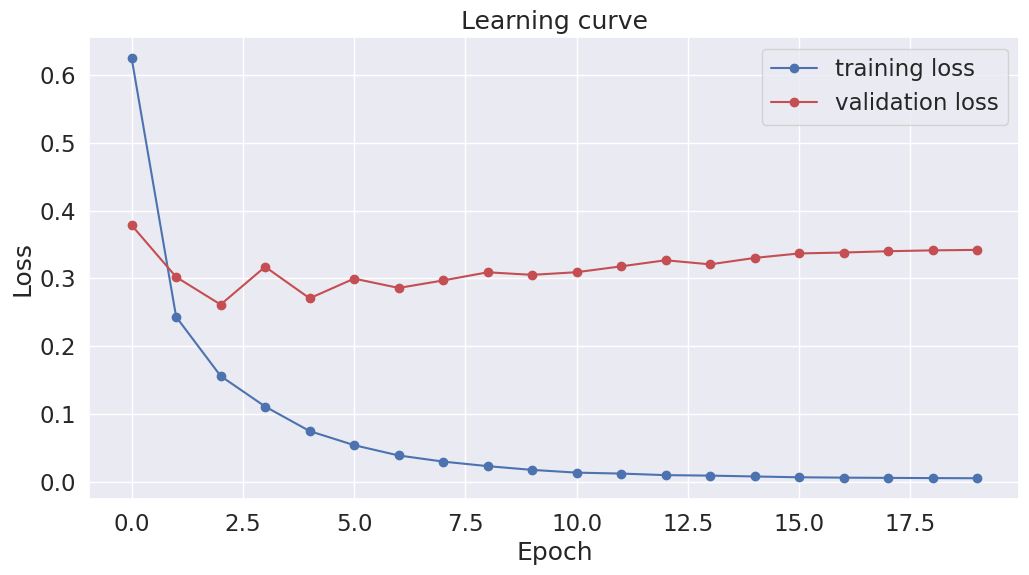

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [38]:
model.save_pretrained('ner_save_model_ssl')

## Test text function

In [38]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
model = AutoModelForTokenClassification.from_pretrained(
    "ner_save_model_eilis",
    )

In [39]:
def calculate_precision_recall(predictions, true_labels, label_idx):
    # Initialize counters for true positives, false positives, and false negatives
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    if all(isinstance(item, list) for item in predictions):
        predictions = [e for pre in predictions for e in pre]
        true_labels = [e for tre in true_labels for e in tre]

    # Iterate through the predictions and true labels
    for prediction, true_label in zip(predictions, true_labels):
        if prediction == label_idx and true_label == label_idx:
            true_positives += 1
        elif prediction == label_idx and true_label != label_idx:
            false_positives += 1
        elif prediction != label_idx and true_label == label_idx:
            false_negatives += 1

    # Calculate precision and recall
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

    return precision, recall

In [40]:
data_list_test = [{'tokens':x, 'tags':y} for x, y in zip(sent_test, label_test) ]
text_data_test = Dataset.from_list(data_list_test)
tokenized_data_test = text_data_test.map(tokenize_text)
tokenized_data_test = tokenized_data_test.remove_columns(['tokens', 'tags'])
test_loader = DataLoader(tokenized_data_test, collate_fn=data_collator)

model.eval()
model.to(device)
# Reset the validation loss for this epoch.
test_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0
predictions , true_labels = [], []
for batch in test_loader:
    batch = {k:v.to(device) for k, v in batch.items()}

    # Telling the model not to compute or store gradients,
    # saving memory and speeding up validation
    with torch.no_grad():
        # Forward pass, calculate logit predictions.
        # This will return the logits rather than the loss because we have not provided labels.
        outputs = model(**batch)
    # Move logits and labels to CPU
    logits = outputs[1].detach().cpu().numpy()
    label_ids = batch['labels'].to('cpu').numpy()

    # Calculate the accuracy for this batch of test sentences.
    test_loss += outputs[0].mean().item()
    predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
    true_labels.extend(label_ids)
test_loss = test_loss / len(val_loader)
print("Test loss: {}".format(test_loss))
pred_tags = [
    [bio_labels[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, true_labels)
]
valid_tags = [
    [bio_labels[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, true_labels)
]
print("Test Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
f1_scores = f1_score(pred_tags, valid_tags, average=None)
print("Test F1-Score:")
for i in range(15):
    print(bio_labels[i*2+1], f1_scores[i])
print("Test F1-Score:{}".format(f1_score(pred_tags, valid_tags)))  # the tags make no sence

Map:   0%|          | 0/86 [00:00<?, ? examples/s]

Test loss: 0.40930253792085103
Test Accuracy: 0.9468113975576662
Test F1-Score:
B-Metal 0.6984126984126984
B-Element 0.6419753086419754
B-Acid 0.4406779661016949
B-Yield 0.952018278750952
B-SeparationMethod 1.0
B-Resin 0.0
B-MethodOfAnalysis 0.40579710144927533
B-pH 0.0
B-ChemicalCompound 0.7326732673267328
B-OrganicSolvent 0.5882352941176471
B-ElementGroup 0.6190476190476191
B-InorganicSolvent 0.6666666666666666
B-Flowrate 0.5662650602409638
B-AcidConcentration 0.08450704225352113
B-Reagent 0.6153846153846153
Test F1-Score:0.7939793038570084


In [24]:
list_tags = []
for pred in valid_tags:
    for e in pred:
        if e not in list_tags:
            list_tags.append(e)

In [30]:
len(set([e for val in pred_tags for e in val]))

27

## other

In [ ]:
import os
os.environ["WANDB_API_KEY"]="API KEY GOES HERE"
os.environ["WANDB_ENTITY"]="Suchandra"
os.environ["WANDB_PROJECT"]="finetune_bert_ner"

In [1]:
import json
with open("barrett2021_annotations.jsonl") as f:
    result = json.load(f)

In [3]:
result['label']

[[227, 231, 'Element-isotope'],
 [232, 237, 'Element-isotope'],
 [241, 252, 'Metal-Ligand Complex'],
 [369, 378, 'Element-isotope'],
 [383, 393, 'Element-isotope'],
 [449, 459, 'Element-isotope'],
 [464, 474, 'Element-isotope'],
 [550, 557, 'ligand'],
 [571, 577, 'Element'],
 [620, 627, 'ligand'],
 [641, 648, 'Element'],
 [653, 660, 'Element'],
 [674, 679, 'Element-isotope'],
 [680, 691, 'Metal-Ligand Complex'],
 [752, 760, 'ligand'],
 [781, 791, 'Element-isotope'],
 [781, 791, 'Element-isotope'],
 [795, 807, 'Element-isotope'],
 [795, 807, 'Element-isotope'],
 [854, 863, 'Element-isotope'],
 [923, 930, 'Element'],
 [1086, 1099, 'Element-isotope'],
 [1228, 1237, 'Element-isotope'],
 [1239, 1249, 'Element-isotope'],
 [1276, 1293, 'Decay mode'],
 [1828, 1838, 'Element-isotope'],
 [1885, 1897, 'Element-isotope'],
 [1958, 1968, 'Element-isotope'],
 [1973, 1985, 'Element-isotope'],
 [2224, 2234, 'Element-isotope'],
 [2312, 2324, 'Element-isotope'],
 [2441, 2451, 'Element-isotope'],
 [2456, 

In [25]:
pred_tags

[['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-Acid',
  'I-Acid',
  'O',
  'B-Acid',
  'O',
  'O',
  'B-SeparationMethod',
  'I-SeparationMethod',
  'O',
  'B-SeparationMethod',
  'O',
  'O',
  'B-SeparationMethod',
  'I-SeparationMethod',
  'O',
  'B-SeparationMethod',
  'O',
  'O',
  'B-Element',
  'O',
  'O',
  'O',
  'O',
  'B-Acid',
  'I-Acid',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-Acid',
  'I-Acid',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-Acid',
  'O',
  'B-Acid',
  'I-Acid',
  'O',
  'O',
  'B-SeparationMethod',
  'O',
  'B-SeparationMethod',
  'O',
  'B-OrganicSolvent',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['B-MethodOfAnalysis',
  'O',
  'O',
  'O',
  'O',
  'B-Element',
  'O',
  'B-Element',
  'O',
  'O',
  'B-Element',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-MethodOfAnalysis',
  'O',
  'O',
  'B-MethodOfAnalysis',
  'O',
  'O',
  'O',
  'B-MethodOfAn

In [ ]:
tokenizer = BertTokenizer.from_pretrained('allenai/scibert_scivocab_cased', do_lower_case=False)


In [37]:
## Test text function

In [25]:
precision_score(pred_tags, valid_tags)

0.6350574712643678

In [57]:
only_predictions = [
        [bio_labels[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, true_labels)
    ]

only_labels = [
        [bio_labels[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, true_labels)
    ]

In [61]:
correct = 0
all = 0
for i in range(len(only_predictions)):
    for j in range(len(only_predictions[i])):
        if only_predictions[i][j] == only_labels[i][j]:
            correct+=1
        all +=1
        
correct/all

0.9468271590510693

In [59]:
accuracy_score(only_predictions, only_labels)

0.9468271590510693

In [58]:
f1_score(only_predictions, only_labels)

0.7316784869976358

In [44]:
accuracy_score(only_predictions, only_labels)

0.9468271590510693

In [ ]:
import evaluate

seqeval = evaluate.load("seqeval")

def compute_metrics(p):
    predictions, labels = p
    #predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [idx2tag[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [idx2tag[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [ ]:
eq

In [22]:
len(valid_tags)

12528

In [21]:
len(pred_tags)

12528

In [39]:
len(predictions[1])

222

In [44]:
np.array(pred_tags)

array([ 0,  0,  0, ..., 14,  0,  0])

In [49]:
accuracy_score(pred_tags, valid_tags)

0.6451562131108838

In [1]:
seqeval.precision([pred_tags], [valid_tags])

NameError: name 'seqeval' is not defined

In [22]:
batch.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])

In [ ]:
training_args = TrainingArguments(
    output_dir="./fine_tune_bert_output",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_steps = 1000,
    run_name = "ep_10_tokenized_11",
    save_strategy='epoch', 
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

In [18]:
model.save_pretrained("ner_save_model")

In [19]:
model = BertForTokenClassification.from_pretrained(
    "allenai/scibert_scivocab_cased",
    num_labels=len(tag2idx), # The number of output labels
    output_attentions = False, # Whether the model returns attention weights.
    output_hidden_states = False # Whether the model returns all hidden-states.
)

Some weights of the model checkpoint at allenai/scibert_scivocab_cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initial

In [1]:
train_dataset

NameError: name 'train_dataset' is not defined

## Test dataset

In [33]:
test_data_list = [{'tokens':x, 'tags':y} for x, y in zip(sent_test, label_test) ]
reduce(s,l,sent_test, label_test)
text_test = Dataset.from_list(test_data_list)
tokenized_test = text_test.map(tokenize_text)
#tokenized_test = tokenized_test.remove_columns(['tokens', 'tags'])

Map:   0%|          | 0/88 [00:00<?, ? examples/s]

In [48]:
from transformers import pipeline
classifier = pipeline("ner", model=model.cpu(), tokenizer=tokenizer)

In [47]:
" ".join(sent_test[0])

'Extraction systems based on extraction of tetrafluoroboric acid ( HBF4 ) with tributyl phosphate ( TBP ) and triamylphosphine oxide ( TAPO ) for boron isotope separation were studied. Tetrafluoroboric acid was studied in comparison with boric acid (H3BO3 ). The extraction isotherms at 20°C for four systems ( boric and tetrafluoroboric acids extracted with TBP and TAPO in o-xylene ) were obtained, and single-stage isotope separation factors for these four systems were determined.'

In [131]:
classifier(" ".join(sent_test[0]))

[{'entity': 'LABEL_0',
  'score': 0.99257624,
  'index': 1,
  'word': 'Extraction',
  'start': None,
  'end': None},
 {'entity': 'LABEL_0',
  'score': 0.9937597,
  'index': 2,
  'word': 'systems',
  'start': None,
  'end': None},
 {'entity': 'LABEL_0',
  'score': 0.9983491,
  'index': 3,
  'word': 'based',
  'start': None,
  'end': None},
 {'entity': 'LABEL_0',
  'score': 0.99838483,
  'index': 4,
  'word': 'on',
  'start': None,
  'end': None},
 {'entity': 'LABEL_0',
  'score': 0.9630412,
  'index': 5,
  'word': 'extraction',
  'start': None,
  'end': None},
 {'entity': 'LABEL_0',
  'score': 0.9925649,
  'index': 6,
  'word': 'of',
  'start': None,
  'end': None},
 {'entity': 'LABEL_5',
  'score': 0.64694345,
  'index': 7,
  'word': 'tetra',
  'start': None,
  'end': None},
 {'entity': 'LABEL_5',
  'score': 0.7829633,
  'index': 8,
  'word': '##fluor',
  'start': None,
  'end': None},
 {'entity': 'LABEL_5',
  'score': 0.63551825,
  'index': 9,
  'word': '##ob',
  'start': None,
  'end

In [29]:
tokenized_test['input_ids']

[[19541,
  1221,
  882,
  201,
  4747,
  125,
  15524,
  18376,
  598,
  15860,
  1441,
  143,
  14688,
  30150,
  30145,
  551,
  188,
  1225,
  24148,
  7147,
  143,
  6520,
  30142,
  551,
  136,
  1225,
  18640,
  6546,
  282,
  7317,
  143,
  29742,
  30159,
  551,
  173,
  9416,
  109,
  18259,
  5622,
  272,
  2600,
  211,
  28069,
  18376,
  598,
  15860,
  1441,
  253,
  2600,
  124,
  2378,
  188,
  9416,
  139,
  1441,
  143,
  233,
  30141,
  22448,
  30141,
  551,
  211,
  186,
  4747,
  19167,
  662,
  262,
  1007,
  30224,
  30138,
  173,
  1603,
  1221,
  143,
  9416,
  139,
  136,
  15524,
  18376,
  598,
  15860,
  4737,
  4453,
  188,
  6520,
  30142,
  136,
  29742,
  30159,
  124,
  114,
  578,
  17788,
  795,
  551,
  272,
  1142,
  430,
  136,
  1267,
  578,
  2553,
  18259,
  5622,
  1426,
  173,
  530,
  1603,
  1221,
  272,
  1829,
  211],
 [26633,
  578,
  12375,
  211,
  186,
  2234,
  125,
  6958,
  1346,
  430,
  1621,
  205,
  430,
  136,
  8534,
  1346,


In [32]:
model(torch.tensor(tokenized_test['input_ids'][0]))

ValueError: not enough values to unpack (expected 2, got 1)

In [50]:
from datasets import load_dataset

wnut = load_dataset("wnut_17")
example = wnut["train"][0]
tokenized_input = tokenizer(example["tokens"], is_split_into_words=True)

Found cached dataset wnut_17 (/global/homes/g/gzhao27/.cache/huggingface/datasets/wnut_17/wnut_17/1.0.0/077c7f08b8dbc800692e8c9186cdf3606d5849ab0e7be662e6135bb10eba54f9)


  0%|          | 0/3 [00:00<?, ?it/s]

In [51]:
tokenized_input

{'input_ids': [101, 5699, 2143, 158, 18857, 30136, 746, 2517, 113, 111, 1892, 277, 593, 179, 2517, 134, 6095, 173, 532, 3363, 211, 3978, 28996, 5453, 15985, 281, 7047, 30154, 211, 27025, 1125, 10381, 23228, 2208, 2653, 27474, 211, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [93]:
tokenized_inputs=tokenizer(example['tokens'], truncation=True, is_split_into_words=True)

In [95]:
tokenized_inputs.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [59]:
example.keys()

dict_keys(['id', 'tokens', 'ner_tags'])

In [96]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [97]:
tokenized_wnut = wnut.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/3394 [00:00<?, ? examples/s]

ValueError: word_ids() is not available when using non-fast tokenizers (e.g. instance of a `XxxTokenizerFast` class).